In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn as nn

# Load the dataset
data_last = pd.read_csv('data/data_last.csv')
data_mkt_cap = pd.read_csv('data/data_mkt_cap.csv')
data_volume = pd.read_csv('data/data_volume.csv')
data_sector = pd.read_csv('data/data_sector.csv')
data_last['date'] = pd.to_datetime(data_last['date'])

# Focus on the closing price for forecasting
data_last_pivot = data_last.sort_values(by='date').pivot(index='date', columns='ticker', values='last')
tickers = data_last_pivot.columns
tickers_num = len(tickers)
print(f'Number of tickers: {tickers_num}')

Number of tickers: 263


In [2]:
# Merge the market capitalization data with sector information
merged_data_sector = pd.merge(data_mkt_cap, data_sector, on='ticker')

# Convert 'date' to datetime format for better handling
merged_data_sector['date'] = pd.to_datetime(merged_data_sector['date'])

# Aggregate market capitalization by sector and date
sector_mkt_cap = merged_data_sector.groupby(['date', 'bics_sector']).agg({'mkt_cap': 'sum'}).reset_index()

# Pivot the data for easier plotting
sector_mkt_cap_pivot = sector_mkt_cap.pivot(index='date', columns='bics_sector', values='mkt_cap')

In [3]:
prices = pd.merge(data_last_pivot, sector_mkt_cap_pivot, on='date')

In [4]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
prices_values = np.nan_to_num(prices.values, 0)
prices_scaled = scaler.fit_transform(prices.values)

# Create sequences of 14 days as input and 7 days as output
def create_sequences(data, input_length, prediction_length):
    xs, ys = [], []
    for i in range(len(data) - input_length - prediction_length + 1):
        x = data[i:(i + input_length)]
        y = data[(i + input_length):(i + input_length + prediction_length)]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

input_length = 28
prediction_length = 7
X, y = create_sequences(prices_scaled, input_length, prediction_length)
y = y[:,:,:tickers_num]


train_size = int((pd.DataFrame(data_last['date'].unique()) < pd.Timestamp(year=2020, month=1, day=1)).sum() + 1 - input_length - prediction_length)
test_size = len(X)  - train_size

In [5]:
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch tensors
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
class TimeSeriesCNN(nn.Module):
    def __init__(self, num_variables, prediction_length, output_features):
        super(TimeSeriesCNN, self).__init__()
        self.num_variables = num_variables
        self.prediction_length = prediction_length
        self.output_features = output_features

        self.conv1 = nn.Conv1d(in_channels=num_variables, out_channels=64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=prediction_length, kernel_size=3, padding=1)
        
        # Adjusting the output size to match the prediction_length and number of variables
        # Assuming the final conv layer produces output of shape [batch_size, prediction_length, adjusted_length]
        # A linear layer to transform the output to the desired shape
        self.fc = nn.Linear(in_features=196, out_features=output_features * prediction_length)

    def forward(self, x):
        # Permute x to match Conv1d input expectations: [batch_size, channels, length]
        x = x.permute(0, 2, 1)
        
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)

        # Flatten the output for the linear layer
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        # Reshape to match the expected output shape [batch_size, prediction_length, num_variables]
        x = x.view(-1, self.prediction_length, self.output_features)
        return x

    
class MultivariateLSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_sequence_length, output_features, num_layers):
        super(MultivariateLSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers 
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_layer_size, output_sequence_length * output_features)
        self.output_sequence_length = output_sequence_length
        self.output_features = output_features

    def forward(self, x):
        h0, c0 = self.init_hidden(x.size(0))
        lstm_out, _ = self.lstm(x, (h0, c0))
        predictions = self.linear(lstm_out[:, -1, :])
        predictions = predictions.view(-1, self.output_sequence_length, self.output_features)
        return predictions

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.lstm.num_layers, batch_size, self.hidden_layer_size)
        cell = torch.zeros(self.lstm.num_layers, batch_size, self.hidden_layer_size)
        return hidden, cell

In [7]:
model = TimeSeriesCNN(num_variables=X_train.size(2), prediction_length=prediction_length, output_features=tickers_num)
# hidden_layer_size = 50
# num_layers = 2
# model = MultivariateLSTM(tickers_num+9, hidden_layer_size , prediction_length, tickers_num, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, criterion, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        for seq, labels in train_loader:
            optimizer.zero_grad()
            output = model(seq)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
        if epoch % 10 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item()}')
        
train(model, train_loader, criterion, optimizer)


Epoch 1, Loss: 0.11239791661500931
Epoch 11, Loss: 0.01347532868385315
Epoch 21, Loss: 0.007000438868999481
Epoch 31, Loss: 0.007224926725029945
Epoch 41, Loss: 0.003931131213903427


In [8]:
def test(model, test_loader):
    predictions = []
    model.eval()
    for seq, labels in test_loader:
        optimizer.zero_grad()
        output = model(seq)
        predictions.append(output.detach().numpy())
    return np.concatenate(predictions)

predictions = test(model, test_loader)[:,0,:]


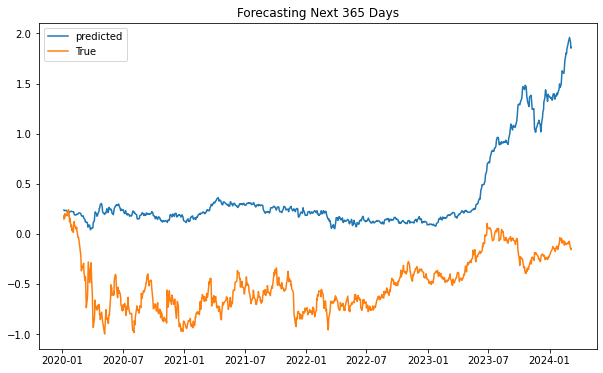

In [9]:
# Plotting
import matplotlib.pyplot as plt

test_date = pd.DataFrame(prices.index[-test_size:])
plt.figure(figsize=(10, 6))
tickersid = np.random.choice(tickers_num, 1)
plt.plot(test_date, predictions[:,tickersid], label='predicted')
plt.plot(test_date, prices_scaled[-test_size:, tickersid], label='True')
plt.legend()
plt.title('Forecasting Next 365 Days')
plt.show()

In [29]:
signals = pd.DataFrame(predictions, columns=tickers, index=prices.index[-test_size:]).pct_change()

In [34]:
# Ensure the 'date' columns are datetime type for all datasets
data_last['date'] = pd.to_datetime(data_last['date'])
data_volume['date'] = pd.to_datetime(data_volume['date'])
data_mkt_cap['date'] = pd.to_datetime(data_mkt_cap['date'])


# Merge the datasets on 'ticker' and 'date'
merged_data = pd.merge(data_last, data_volume, on=['ticker', 'date'])
merged_data = pd.merge(merged_data, data_mkt_cap, on=['ticker', 'date'])

# Sort merged data by date
merged_data.sort_values(by=['date', 'ticker'], inplace=True)
merged_data = merged_data.drop(merged_data[merged_data['date'] < pd.Timestamp(year=2020, month=1, day=1)].index)

merged_data
signals_melt = signals.reset_index().melt(id_vars=['date'], var_name='ticker', value_name='signal')
merged_data_withsignal = pd.merge(merged_data, signals_melt, on=['ticker', 'date'], how='left')



# Function to simulate trades and calculate cumulative profit
def simulate_trades(data, n_stocks=10):
    cumulative_profit = 0
    profits = []

    for date in sorted(data['date'].unique()[-test_size:]):

        todays_data = data[data['date'] == date]
        todays_data = todays_data.sort_values(by='signal', ascending=False).head(n_stocks)
        
        # Simulate buying at closing price and selling at next day's closing price
        for index, row in todays_data.iterrows():
            buy_price = row['last']
            ticker = row['ticker']
            try:
                # Assume selling at next available closing price
                sell_price = data[(data['ticker'] == ticker) & (data['date'] > date)].iloc[0]['last']
                profit = sell_price - buy_price
                cumulative_profit += profit
                profits.append(profit)
            except IndexError:
                # No next day data to sell, assuming end of dataset
                pass
    
    return cumulative_profit, profits

In [36]:
top_k = 5
cumulative_profit, profits =simulate_trades(merged_data_withsignal, top_k)
print(f'Cumulative profit: {cumulative_profit}')

Cumulative profit: 6578.699999999998


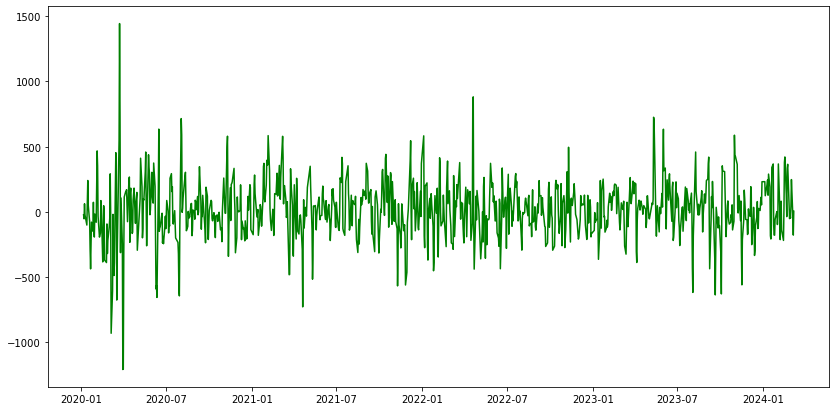

In [40]:
summed_profits = [sum(profits[i:i+10]) for i in range(0, len(profits), top_k)]
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(data_last['date'].unique()[-test_size+1:],summed_profits, color='green')